In [4]:
import dataset

In [5]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [6]:
root_name = "/home/h6x/git_projects/ornl-gnn-experiment/model_1/going_modular/data"

In [7]:
dataset =dataset.OpioidDataset(root_name, test=False)

In [8]:
# Print information
print(dataset)
print('------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

OpioidDataset()
------------
Number of graphs: 1
Number of features: 15
Number of classes: 2


In [9]:
data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(x=[3141, 15], edge_index=[2, 18224], y=[3141])
Number of nodes: 3141
Number of edges: 18224
Average node degree: 5.80
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [10]:
# Print first element
print(f'Graph: {dataset[0]}')

Graph: Data(x=[3141, 15], edge_index=[2, 18224], y=[3141])


In [11]:
print(f'x = {data.x.shape}')
print(data.x)

x = torch.Size([3141, 15])
tensor([[0.1416, 0.1938, 0.1613,  ..., 0.0426, 0.1572, 0.0377],
        [0.2759, 0.4187, 0.1321,  ..., 0.1217, 0.1230, 0.0287],
        [0.1488, 0.1488, 0.1398,  ..., 0.0609, 0.1800, 0.0431],
        ...,
        [0.4410, 0.3253, 0.2934,  ..., 0.0304, 0.1321, 0.0108],
        [0.3956, 0.3149, 0.2135,  ..., 0.0426, 0.3292, 0.0700],
        [0.4083, 0.1869, 0.1659,  ..., 0.0162, 0.1378, 0.0754]])


In [12]:
from torch_geometric.utils import to_dense_adj

In [13]:
A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (3141, 3141)
[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [14]:
print(f'y = {data.y.shape}')
print(data.y)

y = torch.Size([3141])
tensor([0, 0, 0,  ..., 1, 1, 1])


In [15]:
from torch_geometric.utils import to_networkx

In [16]:
# G = to_networkx(data, to_undirected=True)
# plt.figure(figsize=(12,12))
# plt.axis('off')
# nx.draw_networkx(G,
#                 pos=nx.spring_layout(G, seed=0),
#                 with_labels=True,
#                 node_size=800,
#                 node_color=data.y,
#                 cmap="hsv",
#                 vmin=-2,
#                 vmax=3,
#                 width=0.8,
#                 edge_color="grey",
#                 font_size=14
#                 )
# plt.show()

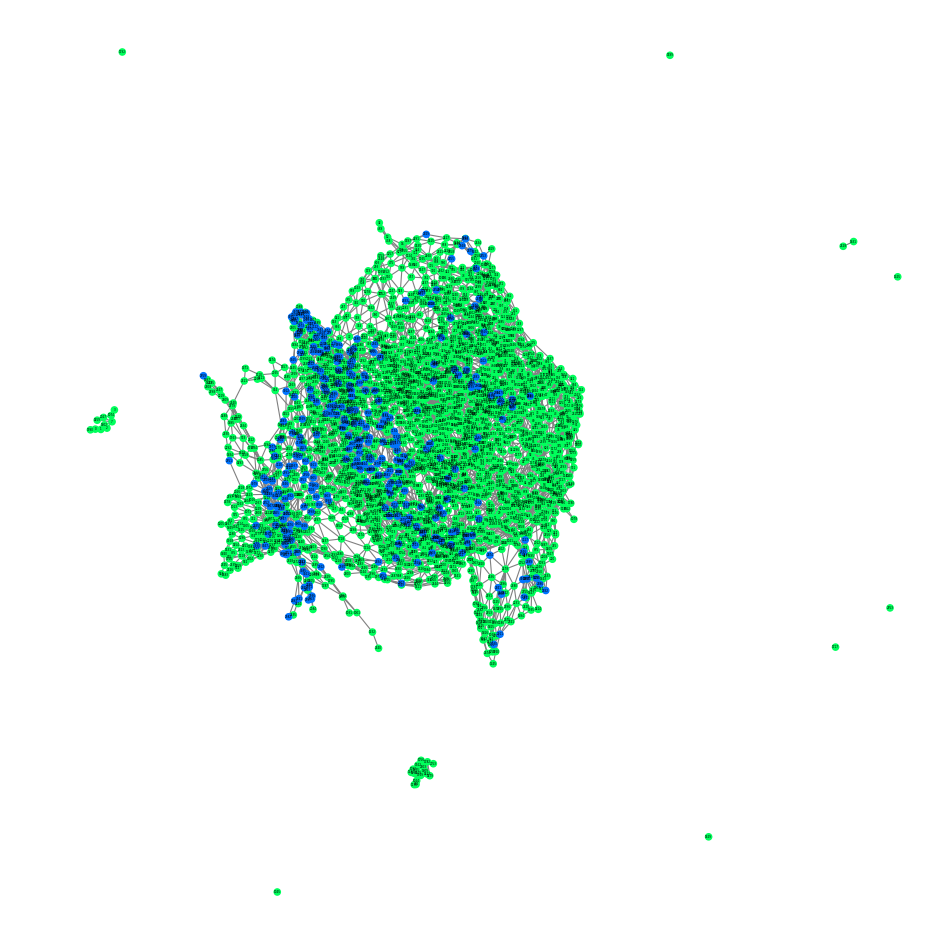

In [18]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=20,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=2
                )
plt.show()

In [17]:
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [18]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)
    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index).relu()
        z = self.out(h)
        return h, z
model = GCN()
print(model)

GCN(
  (gcn): GCNConv(15, 3)
  (out): Linear(in_features=3, out_features=2, bias=True)
)


In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.012)

In [20]:
# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)
# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []
# Training loop
for epoch in range(2001):
    # Clear gradients
    optimizer.zero_grad()
    # Forward pass
    h, z = model(data.x, data.edge_index)
    # Calculate loss function
    loss = criterion(z, data.y)
    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)
    # Compute gradients
    loss.backward()
    # Tune parameters
    optimizer.step()
    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))
    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 0.69 | Acc: 62.11%
Epoch  10 | Loss: 0.46 | Acc: 90.04%
Epoch  20 | Loss: 0.33 | Acc: 90.04%
Epoch  30 | Loss: 0.33 | Acc: 90.04%
Epoch  40 | Loss: 0.33 | Acc: 90.04%
Epoch  50 | Loss: 0.32 | Acc: 90.04%
Epoch  60 | Loss: 0.32 | Acc: 90.04%
Epoch  70 | Loss: 0.32 | Acc: 90.04%
Epoch  80 | Loss: 0.32 | Acc: 90.04%
Epoch  90 | Loss: 0.32 | Acc: 90.04%
Epoch 100 | Loss: 0.31 | Acc: 90.04%
Epoch 110 | Loss: 0.31 | Acc: 90.04%
Epoch 120 | Loss: 0.31 | Acc: 90.04%
Epoch 130 | Loss: 0.31 | Acc: 90.04%
Epoch 140 | Loss: 0.30 | Acc: 90.04%
Epoch 150 | Loss: 0.30 | Acc: 90.04%
Epoch 160 | Loss: 0.30 | Acc: 90.04%
Epoch 170 | Loss: 0.30 | Acc: 90.04%
Epoch 180 | Loss: 0.29 | Acc: 90.04%
Epoch 190 | Loss: 0.29 | Acc: 90.04%
Epoch 200 | Loss: 0.29 | Acc: 90.04%
Epoch 210 | Loss: 0.29 | Acc: 90.04%
Epoch 220 | Loss: 0.28 | Acc: 90.04%
Epoch 230 | Loss: 0.28 | Acc: 90.04%
Epoch 240 | Loss: 0.28 | Acc: 90.04%
Epoch 250 | Loss: 0.28 | Acc: 90.04%
Epoch 260 | Loss: 0.28 | Acc: 90.04%
E

In [21]:
%%capture
from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

In [22]:
# def animate(i):
#     G = to_networkx(data, to_undirected=True)
#     nx.draw_networkx(G,
#                     pos=nx.spring_layout(G, seed=0),
#                     with_labels=True,
#                     node_size=800,
#                     node_color=outputs[i],
#                     cmap="hsv",
#                     vmin=-2,
#                     vmax=3,
#                     width=0.8,
#                     edge_color="grey",
#                     font_size=14
#                     )
#     plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
#               fontsize=18, pad=20)
    
def animate(i):
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=10,
                    node_color=outputs[i],
                    cmap="hsv",
                    vmin=-2,
                    vmax=3,
                    width=0.8,
                    edge_color="grey",
                    font_size=2
                    )
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f} | Acc: {accuracies[i]*100:.2f}%',
              fontsize=18, pad=20)

MovieWriter imagemagick unavailable; using Pillow instead.


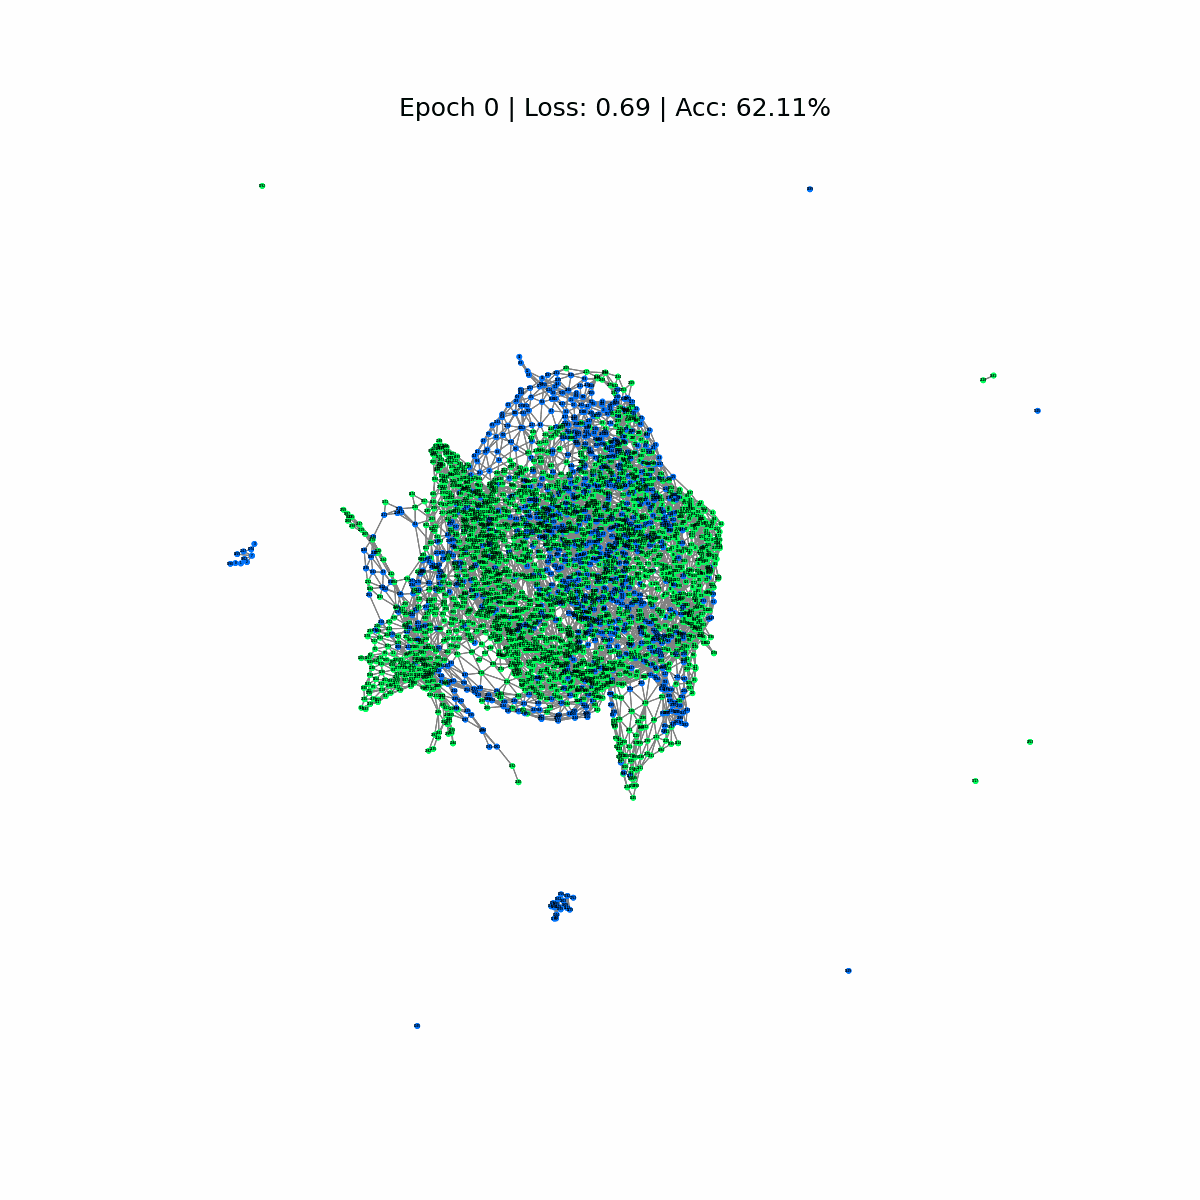

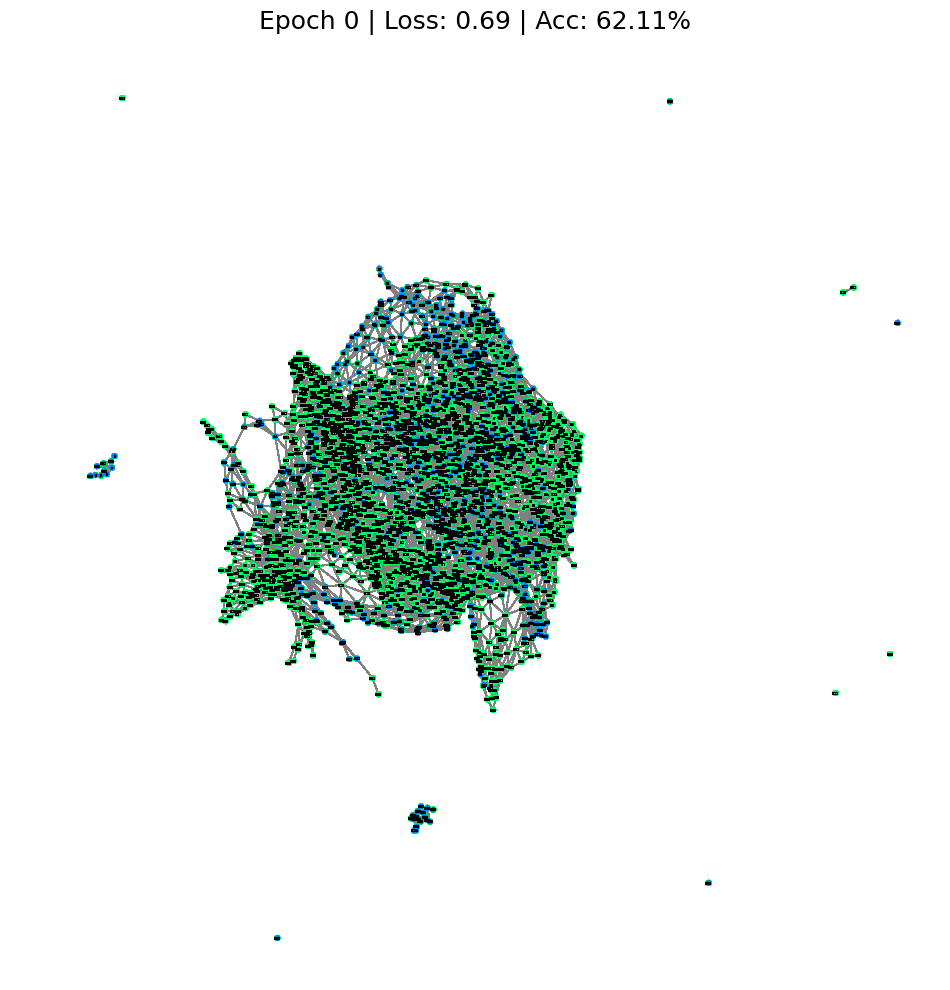

In [23]:
fig = plt.figure(figsize=(12, 12))
plt.axis('off')

anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 1000, 10), interval=5000, repeat=True)

# Save the animation as a GIF
anim.save("animation_us.gif", writer='imagemagick', fps=30, bitrate=3000)

# Optionally, display the GIF in Jupyter Notebook
from IPython.display import Image
display(Image(filename="animation_us.gif"))

In [ ]:
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
anim = animation.FuncAnimation(fig, animate, \
            np.arange(0, 200, 10), interval=500, repeat=True)
html = HTML(anim.to_html5_video())
display(html)

In [ ]:
# Print embeddings
print(f'Final embeddings = {h.shape}')
print(h)

In [22]:
# Get first embedding at epoch = 0
embed = h.detach().cpu().numpy()

In [ ]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
plt.show()